In [1]:
import sys
sys.path.append(".")
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.config import ACTIVITIES, ABBR, TZ_PARIS, TZ_LONDON
from src.viz_style import apply_nature_style

apply_nature_style()

In [3]:
from src.utils_time import to_local_time_series, split_cross_midnight, week_start_monday
from src.utils_split import split_users_by_hash
from src.regularity import regularity_report, summarize_reg, compute_user_hex_stats, infer_home_work_anchors, make_hex_lookup

In [4]:
from pathlib import Path

ROOT = Path(".")
OUT_DATA = ROOT / "outputs" / "data"
OUT_FIG  = ROOT / "outputs" / "figures"
OUT_FIG.mkdir(parents=True, exist_ok=True)

labels = ["HOME","WORK","STUDY","PURCHASE","LEISURE","HEALTH","OTHER"]

paths = {
    "Rule-based": OUT_DATA / "cm_baseline1_parisS3_huff_row_norm.csv",
    "GBDT":       OUT_DATA / "cm_gbdt_row_norm.csv",
    "HMM":        OUT_DATA / "cm_hmm_paris_huff_grid_row_norm.csv",
    "Hybrid":     OUT_DATA / "cm_hybrid_row_norm.csv",
}

cms = {}
for name, p in paths.items():
    cms[name] = np.loadtxt(p, delimiter=",")
    print(name, "shape", cms[name].shape, "from", p.name)

Rule-based shape (7, 7) from cm_baseline1_parisS3_huff_row_norm.csv
GBDT shape (7, 7) from cm_gbdt_row_norm.csv
HMM shape (7, 7) from cm_hmm_paris_huff_grid_row_norm.csv
Hybrid shape (7, 7) from cm_hybrid_row_norm.csv


In [5]:
# Optional helper to save row-norm CM from y_true/y_pred arrays
from sklearn.metrics import confusion_matrix

def save_row_norm_cm(y_true, y_pred, out_csv, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cmn = cm / np.maximum(cm.sum(axis=1, keepdims=True), 1)
    np.savetxt(out_csv, cmn, delimiter=",", fmt="%.6f")
    print("Saved:", out_csv)
    return cmn

In [6]:
summary = pd.DataFrame([
    {"model":"Rule-based", "ACC":0.4418268071, "Macro":0.3100359106, "Macro_weak":0.2508782713},
    {"model":"GBDT",       "ACC":0.6265980542, "Macro":0.4907338509, "Macro_weak":0.4275618680},
    {"model":"HMM",        "ACC":0.5750582938, "Macro":0.4204120026, "Macro_weak":0.3603642371},
    {"model":"Hybrid",     "ACC":0.6690520222, "Macro":0.5128403271, "Macro_weak":0.4500497426},
]).sort_values("Macro_weak", ascending=False)

out_csv = OUT_DATA / "paris_model_compare_summary_4models.csv"
summary.to_csv(out_csv, index=False)
print("Saved:", out_csv)
summary

Saved: /Users/pang/Codes/GISRUK/outputs/data/paris_model_compare_summary_4models.csv


,model,ACC,Macro,Macro_weak
3,Hybrid,0.669052,0.512840,0.450050
1,GBDT,0.626598,0.490734,0.427562
2,HMM,0.575058,0.420412,0.360364
0,Rule-based,0.441827,0.310036,0.250878


/var/folders/5z/f4gzbtkn3kb0xq5k22hdlj7h0000gn/T/ipykernel_21599/4157473425.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.02, 0.02, 0.90, 0.94])


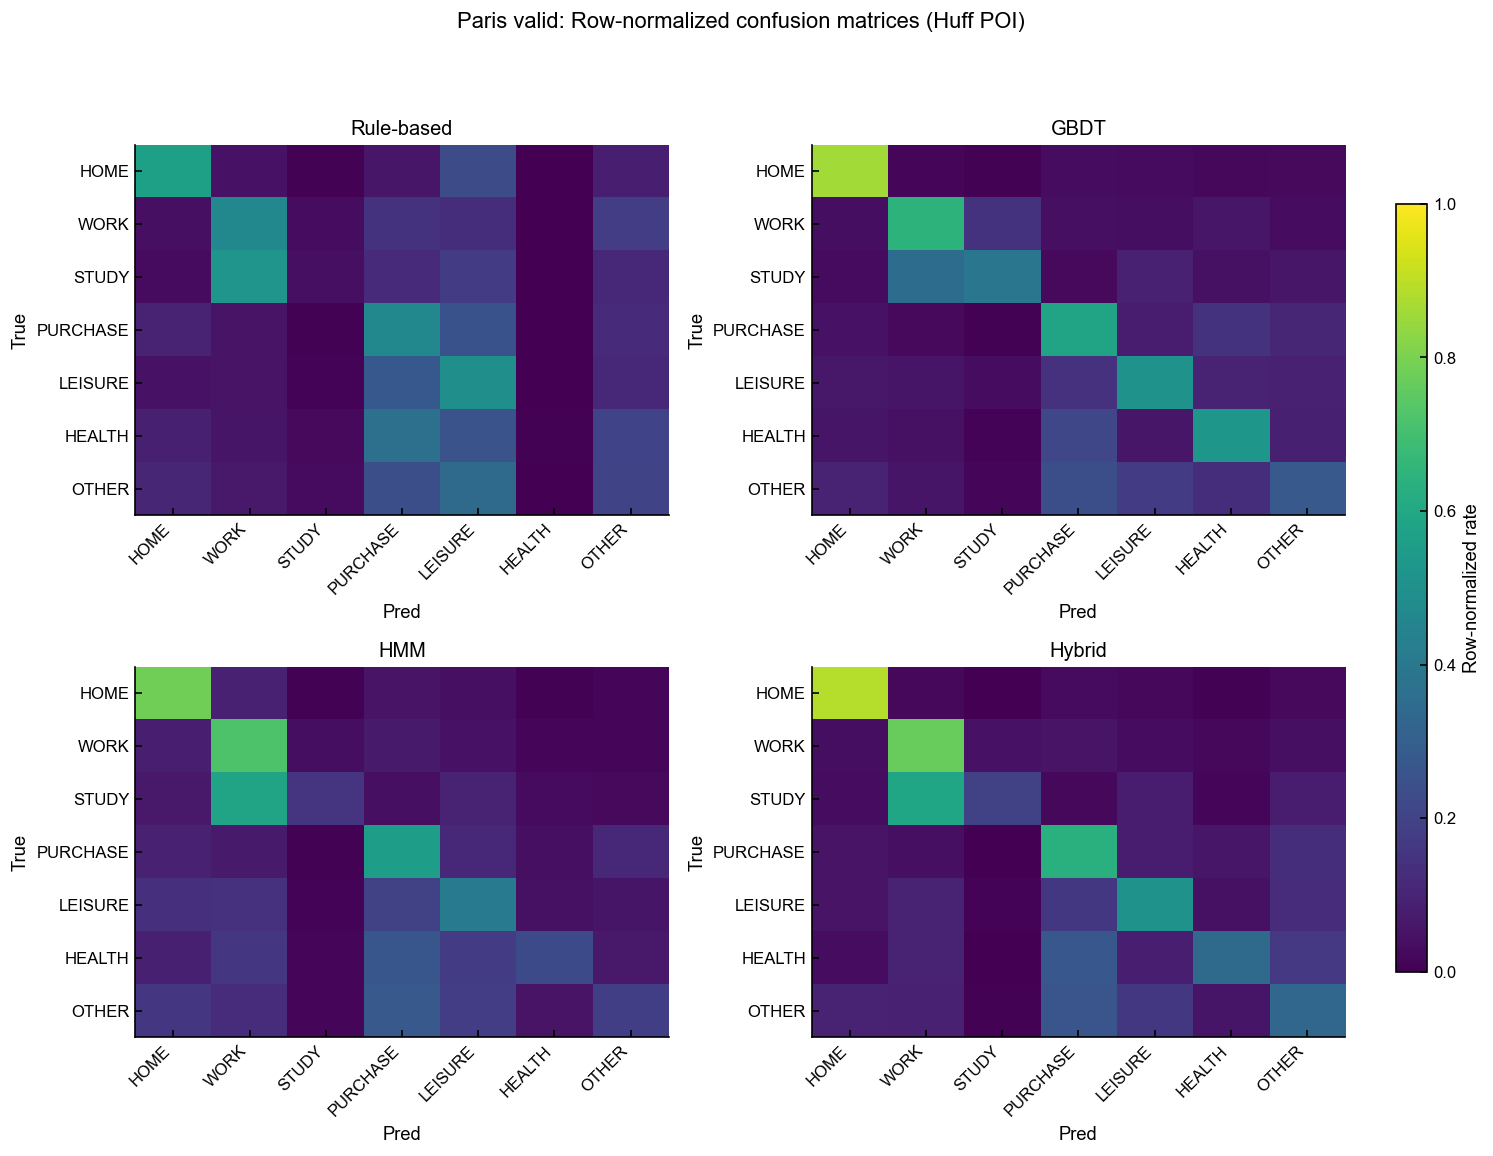

Saved: /Users/pang/Codes/GISRUK/outputs/figures/paris_4models_cm_panel.png


In [11]:
import matplotlib.pyplot as plt
import numpy as np

apply_nature_style()

def plot_4cm_panel(cms, labels, outpath, title):
    fig, axes = plt.subplots(2, 2, figsize=(13, 10))
    axes = axes.flatten()

    order = ["Rule-based", "GBDT", "HMM", "Hybrid"]

    im = None
    for ax, name in zip(axes, order):
        cm = cms[name]
        im = ax.imshow(cm, vmin=0.0, vmax=1.0, aspect="auto")
        ax.set_title(name)
        ax.set_xlabel("Pred")
        ax.set_ylabel("True")
        ax.set_xticks(np.arange(len(labels)))
        ax.set_yticks(np.arange(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha="right")
        ax.set_yticklabels(labels)
        ax.tick_params(direction="in")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # --- shared colorbar on the right (no overlap) ---
    cax = fig.add_axes([0.92, 0.18, 0.02, 0.64])  # [left, bottom, width, height] in figure coords
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params(direction="in")
    cbar.set_label("Row-normalized rate")

    fig.suptitle(title, y=0.98)

    # Leave room for suptitle + colorbar
    fig.tight_layout(rect=[0.02, 0.02, 0.90, 0.94])

    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print("Saved:", outpath)

plot_4cm_panel(
    cms=cms,
    labels=labels,
    outpath=str(OUT_FIG / "paris_4models_cm_panel.png"),
    title="Paris valid: Row-normalized confusion matrices (Huff POI)"
)

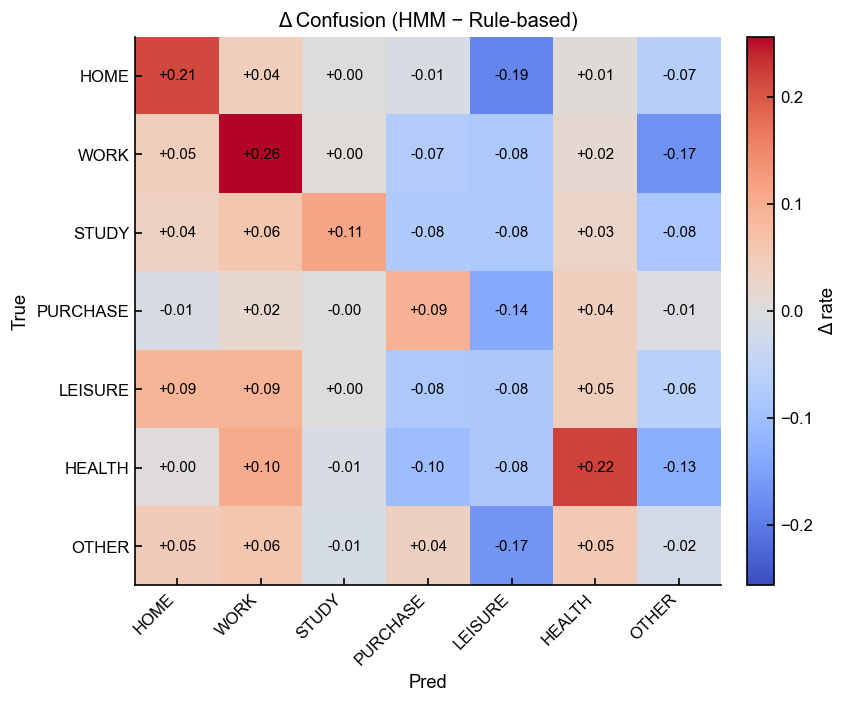

Saved: /Users/pang/Codes/GISRUK/outputs/figures/diff_hmm_minus_rulebased.png


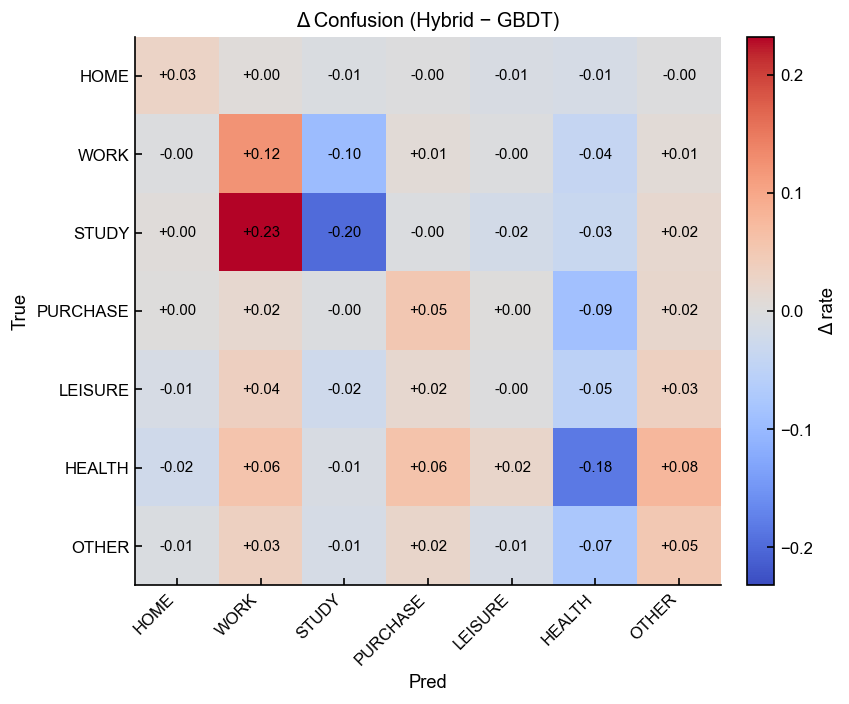

Saved: /Users/pang/Codes/GISRUK/outputs/figures/diff_hybrid_minus_gbdt.png


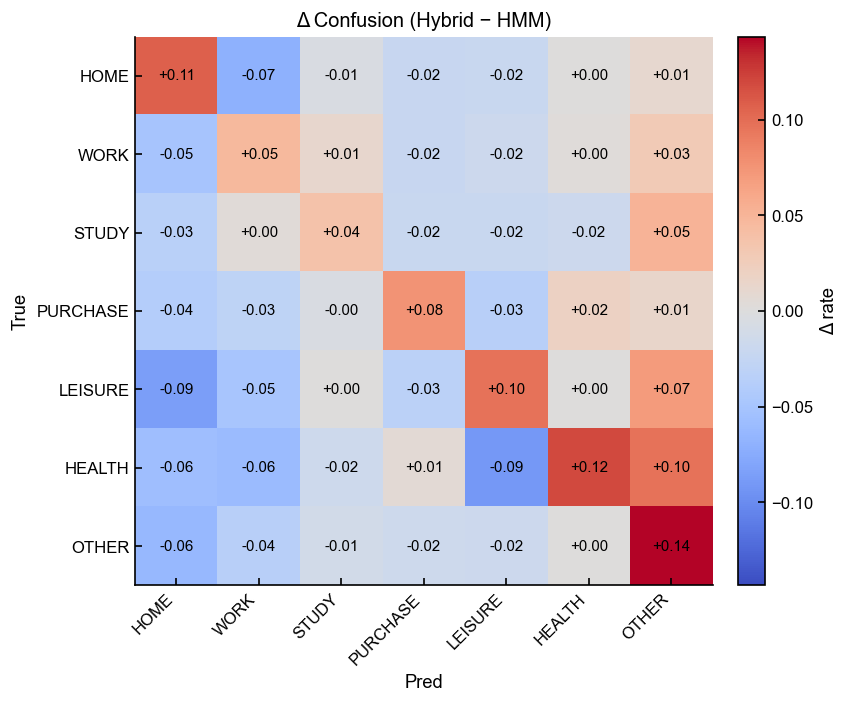

Saved: /Users/pang/Codes/GISRUK/outputs/figures/diff_hybrid_minus_hmm.png


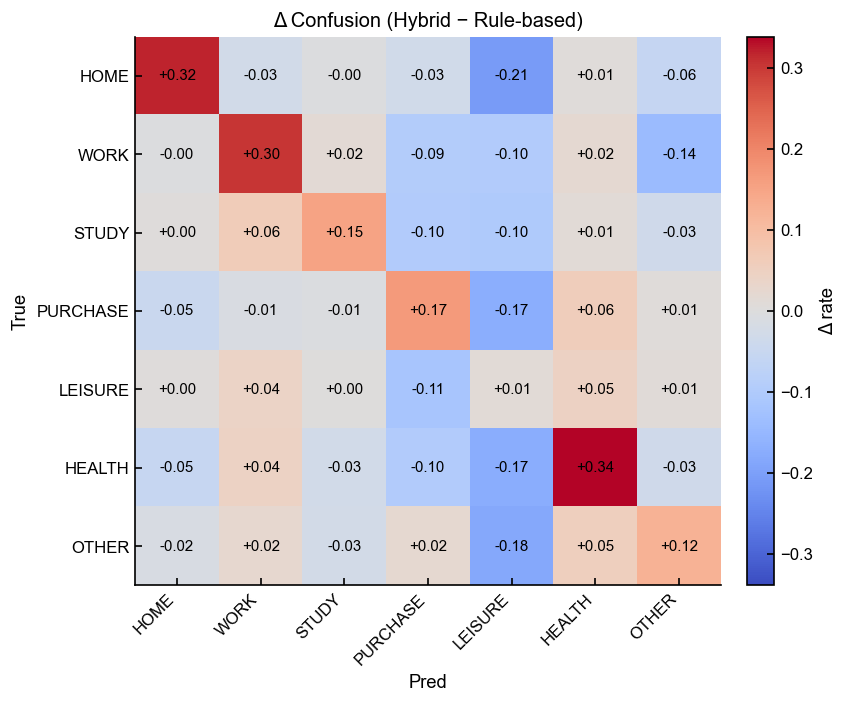

Saved: /Users/pang/Codes/GISRUK/outputs/figures/diff_hybrid_minus_rulebased.png


In [9]:
def plot_diff(cm_diff, labels, title, outpath, annotate=True):
    vmax = float(np.max(np.abs(cm_diff))) or 1e-6
    fig, ax = plt.subplots(figsize=(7.2, 6.0))
    im = ax.imshow(cm_diff, vmin=-vmax, vmax=vmax, aspect="auto", cmap="coolwarm")
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(direction="in")
    cbar.set_label("Δ rate")
    ax.set_title(title)
    ax.set_xlabel("Pred")
    ax.set_ylabel("True")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    ax.tick_params(direction="in")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if annotate:
        for i in range(len(labels)):
            for j in range(len(labels)):
                ax.text(j, i, f"{cm_diff[i,j]:+.2f}", ha="center", va="center", fontsize=9)
    plt.tight_layout()
    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print("Saved:", outpath)

diff1 = cms["HMM"] - cms["Rule-based"]
diff2 = cms["Hybrid"] - cms["GBDT"]
diff3 = cms["Hybrid"] - cms["HMM"]
diff4 = cms["Hybrid"] - cms["Rule-based"]

plot_diff(diff1, labels, "Δ Confusion (HMM − Rule-based)", str(OUT_FIG / "diff_hmm_minus_rulebased.png"))
plot_diff(diff2, labels, "Δ Confusion (Hybrid − GBDT)", str(OUT_FIG / "diff_hybrid_minus_gbdt.png"))
plot_diff(diff3, labels, "Δ Confusion (Hybrid − HMM)", str(OUT_FIG / "diff_hybrid_minus_hmm.png"))
plot_diff(diff4, labels, "Δ Confusion (Hybrid − Rule-based)", str(OUT_FIG / "diff_hybrid_minus_rulebased.png"))

In [10]:
best = summary.iloc[0]
print("Best model:", best["model"])
print(summary.to_string(index=False))

Best model: Hybrid
     model      ACC    Macro  Macro_weak
    Hybrid 0.669052 0.512840    0.450050
      GBDT 0.626598 0.490734    0.427562
       HMM 0.575058 0.420412    0.360364
Rule-based 0.441827 0.310036    0.250878


In [16]:
# from pathlib import Path
# import pandas as pd
# import numpy as np

ROOT = Path(".")
OUT_DATA = ROOT / "outputs" / "data"
OUT_FIG  = ROOT / "outputs" / "figures"
OUT_TAB  = ROOT / "outputs" / "tables"
OUT_FIG.mkdir(parents=True, exist_ok=True)
OUT_TAB.mkdir(parents=True, exist_ok=True)

# labels = ["HOME","WORK","STUDY","PURCHASE","LEISURE","HEALTH","OTHER"]

pred_paths = {
    "Rule-based": OUT_DATA / "paris_valid_pred_rulebased.parquet",
    "GBDT":       OUT_DATA / "paris_valid_pred_gbdt.parquet",
    "HMM":        OUT_DATA / "paris_valid_pred_hmm.parquet",
    "Hybrid":     OUT_DATA / "paris_valid_pred_hybrid.parquet",
}

pred = {}
for name, p in pred_paths.items():
    if not p.exists():
        raise FileNotFoundError(f"Missing {name} predictions: {p}. Please save it from the corresponding notebook.")
    df = pd.read_parquet(p)
    df["user_id"] = df["user_id"].astype(str)
    df["start_time"] = pd.to_datetime(df["start_time"])
    df["end_time"] = pd.to_datetime(df["end_time"])
    df["hex_id"] = df["hex_id"].astype(str)
    df["y_true"] = df["y_true"].astype(str)
    df["y_pred"] = df["y_pred"].astype(str)
    pred[name] = df
    print(name, "rows:", len(df), "users:", df["user_id"].nunique())

Rule-based rows: 12437 users: 621
GBDT rows: 12437 users: 621
HMM rows: 12437 users: 621
Hybrid rows: 12437 users: 621


Saved: /Users/pang/Codes/GISRUK/outputs/tables/paris_activity_share_by_count_4models.csv


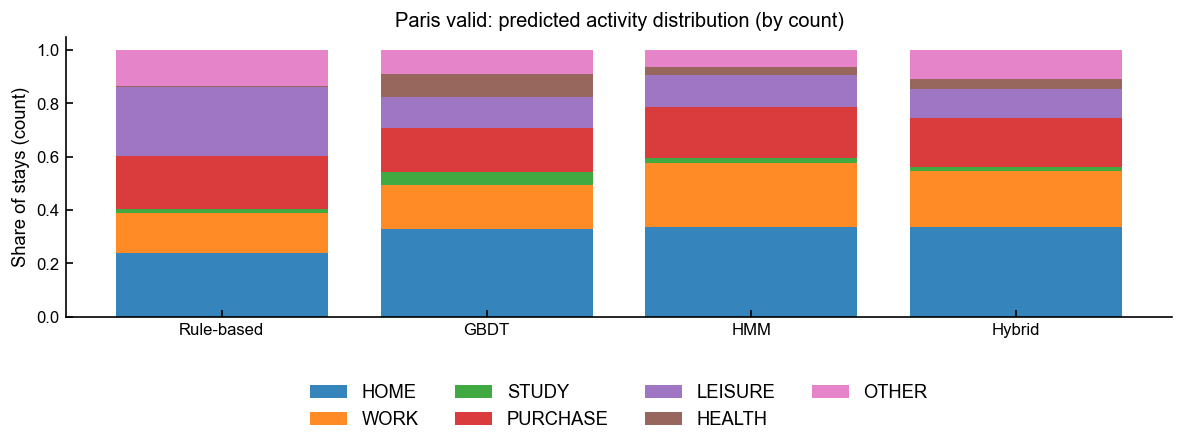

Saved: /Users/pang/Codes/GISRUK/outputs/figures/paris_activity_share_count_4models.png


In [17]:
apply_nature_style()
import matplotlib.pyplot as plt

dist_rows = []
for name, df in pred.items():
    share = df["y_pred"].value_counts(normalize=True).reindex(labels, fill_value=0)
    dist_rows.append(pd.Series(share, name=name))
dist_df = pd.DataFrame(dist_rows)

# save table
dist_df.to_csv(OUT_TAB / "paris_activity_share_by_count_4models.csv")
print("Saved:", OUT_TAB / "paris_activity_share_by_count_4models.csv")

# stacked bar
fig, ax = plt.subplots(figsize=(10, 4))
bottom = np.zeros(len(dist_df))
x = np.arange(len(dist_df))
for lab in labels:
    ax.bar(x, dist_df[lab].values, bottom=bottom, label=lab, alpha=0.9)
    bottom += dist_df[lab].values

ax.set_xticks(x)
ax.set_xticklabels(dist_df.index.tolist(), rotation=0)
ax.set_ylabel("Share of stays (count)")
ax.set_title("Paris valid: predicted activity distribution (by count)")
ax.legend(ncol=4, loc="upper center", bbox_to_anchor=(0.5, -0.18))
ax.tick_params(direction="in")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
out_png = OUT_FIG / "paris_activity_share_count_4models.png"
fig.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print("Saved:", out_png)

Saved: /Users/pang/Codes/GISRUK/outputs/tables/paris_activity_share_by_duration_4models.csv


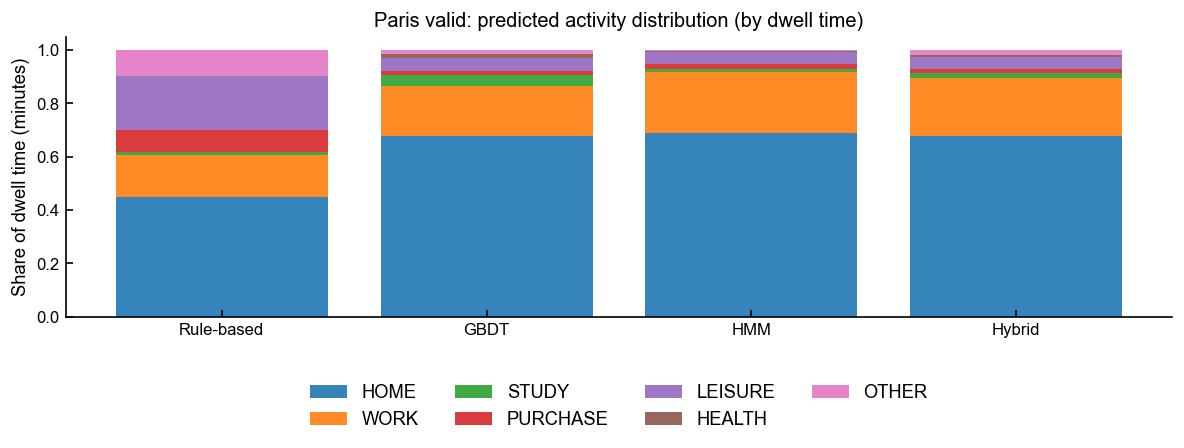

Saved: /Users/pang/Codes/GISRUK/outputs/figures/paris_activity_share_dwell_4models.png


In [18]:
dist_rows = []
for name, df in pred.items():
    g = df.groupby("y_pred")["duration_min"].sum()
    share = (g / g.sum()).reindex(labels, fill_value=0)
    dist_rows.append(pd.Series(share, name=name))
dist_dur = pd.DataFrame(dist_rows)

dist_dur.to_csv(OUT_TAB / "paris_activity_share_by_duration_4models.csv")
print("Saved:", OUT_TAB / "paris_activity_share_by_duration_4models.csv")

fig, ax = plt.subplots(figsize=(10, 4))
bottom = np.zeros(len(dist_dur))
x = np.arange(len(dist_dur))
for lab in labels:
    ax.bar(x, dist_dur[lab].values, bottom=bottom, label=lab, alpha=0.9)
    bottom += dist_dur[lab].values

ax.set_xticks(x)
ax.set_xticklabels(dist_dur.index.tolist(), rotation=0)
ax.set_ylabel("Share of dwell time (minutes)")
ax.set_title("Paris valid: predicted activity distribution (by dwell time)")
ax.legend(ncol=4, loc="upper center", bbox_to_anchor=(0.5, -0.18))
ax.tick_params(direction="in")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
out_png = OUT_FIG / "paris_activity_share_dwell_4models.png"
fig.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print("Saved:", out_png)

In [30]:
from src.utils_time import to_local_time_series, split_cross_midnight
from src.config import ABBR, TZ_PARIS

def collapse_consecutive(labels_list):
    out=[]
    for x in labels_list:
        if len(out)==0 or x!=out[-1]:
            out.append(x)
    return out

def build_daily_patterns_from_pred(df, label_col="y_pred", min_dur_min=10):
    d = df.copy()
    d["start_time"] = to_local_time_series(d["start_time"], tz=TZ_PARIS, assume_utc_if_naive=False)
    d["end_time"]   = to_local_time_series(d["end_time"], tz=TZ_PARIS, assume_utc_if_naive=False)
    d["duration_min"] = pd.to_numeric(d["duration_min"], errors="coerce")
    d = d.dropna(subset=["user_id","start_time","end_time","duration_min",label_col]).copy()
    d = d[d["duration_min"] > 0].copy()

    d = split_cross_midnight(d)
    d = d[d["duration_min"] >= float(min_dur_min)].copy()

    d["date"] = d["start_time"].dt.date
    d["dow"] = d["start_time"].dt.weekday

    rows=[]
    for (u, date), g in d.groupby(["user_id","date"], sort=False):
        g = g.sort_values("start_time")
        labs = [x for x in g[label_col].astype(str).tolist() if x in ABBR]
        if not labs:
            continue
        labs2 = collapse_consecutive(labs)
        patt = "-".join([ABBR[x] for x in labs2])
        rows.append((u, date, int(g["dow"].iloc[0]), patt))
    return pd.DataFrame(rows, columns=["user_id","date","dow","pattern"])

# Build patterns per model
pat = {}
for name, df in pred.items():
    pat[name] = build_daily_patterns_from_pred(df, label_col="y_pred", min_dur_min=20)
    print(name, "user-days:", len(pat[name]))

# Choose a common pattern set based on Hybrid (or y_true, if you prefer)
base_for_patterns = "Hybrid"
vc = pat[base_for_patterns]["pattern"].value_counts()
coverage = 0.90
min_count = 20

vc2 = vc[vc >= min_count]
cum = vc2.cumsum()/vc2.sum()
top_patterns = vc2.index[cum <= coverage].tolist()
top_patterns = top_patterns[:12]  # keep slide-friendly
print("Top patterns used for comparison:", top_patterns)

def pattern_share_table(pat_df, top_patterns):
    tmp = pat_df.copy()
    tmp["pattern2"] = tmp["pattern"].where(tmp["pattern"].isin(top_patterns), other="Other")
    share = tmp["pattern2"].value_counts(normalize=True)
    return share.reindex(top_patterns + ["Other"], fill_value=0)

share_rows = []
for name in pred.keys():
    share_rows.append(pattern_share_table(pat[name], top_patterns).rename(name))
share_pat = pd.DataFrame(share_rows)

share_pat.to_csv(OUT_TAB / "paris_pattern_share_4models.csv")
print("Saved:", OUT_TAB / "paris_pattern_share_4models.csv")
share_pat

Rule-based user-days: 3628
GBDT user-days: 3628
HMM user-days: 3628
Hybrid user-days: 3628
Top patterns used for comparison: ['H-W-H', 'H', 'W-H', 'H-L-H', 'H-P-H', 'H-L', 'H-W', 'H-W-L-H', 'H-P', 'H-O-H', 'H-W-H-L-H', 'H-W-P-H']
Saved: /Users/pang/Codes/GISRUK/outputs/tables/paris_pattern_share_4models.csv


,H-W-H,H,W-H,H-L-H,H-P-H,H-L,H-W,H-W-L-H,H-P,H-O-H,H-W-H-L-H,H-W-P-H,Other
Rule-based,0.039691,0.063396,0.030595,0.021499,0.023429,0.035281,0.011025,0.009923,0.025358,0.019294,0.003308,0.007166,0.710033
GBDT,0.115766,0.111356,0.060364,0.039967,0.032800,0.037211,0.025358,0.017641,0.017916,0.007166,0.011301,0.007442,0.515711
HMM,0.192944,0.105843,0.073319,0.060915,0.039140,0.036384,0.042448,0.027288,0.018467,0.004961,0.034454,0.034730,0.329107
Hybrid,0.160970,0.097850,0.070011,0.042723,0.041621,0.035832,0.035006,0.024531,0.019570,0.019570,0.016262,0.015987,0.420066


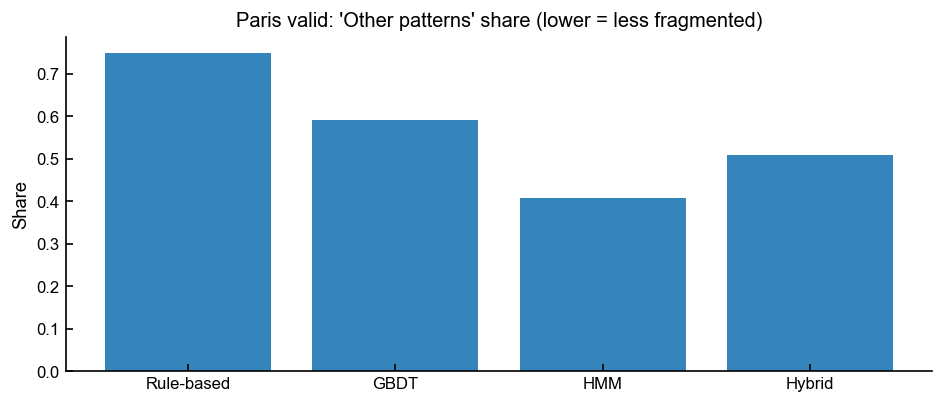

Saved: /Users/pang/Codes/GISRUK/outputs/figures/paris_other_patterns_share_4models.png


In [20]:
apply_nature_style()
fig, ax = plt.subplots(figsize=(8, 3.5))
x = np.arange(len(share_pat))
ax.bar(x, share_pat["Other"].values, alpha=0.9)
ax.set_xticks(x)
ax.set_xticklabels(share_pat.index.tolist())
ax.set_ylabel("Share")
ax.set_title("Paris valid: 'Other patterns' share (lower = less fragmented)")
ax.tick_params(direction="in")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
out_png = OUT_FIG / "paris_other_patterns_share_4models.png"
fig.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print("Saved:", out_png)

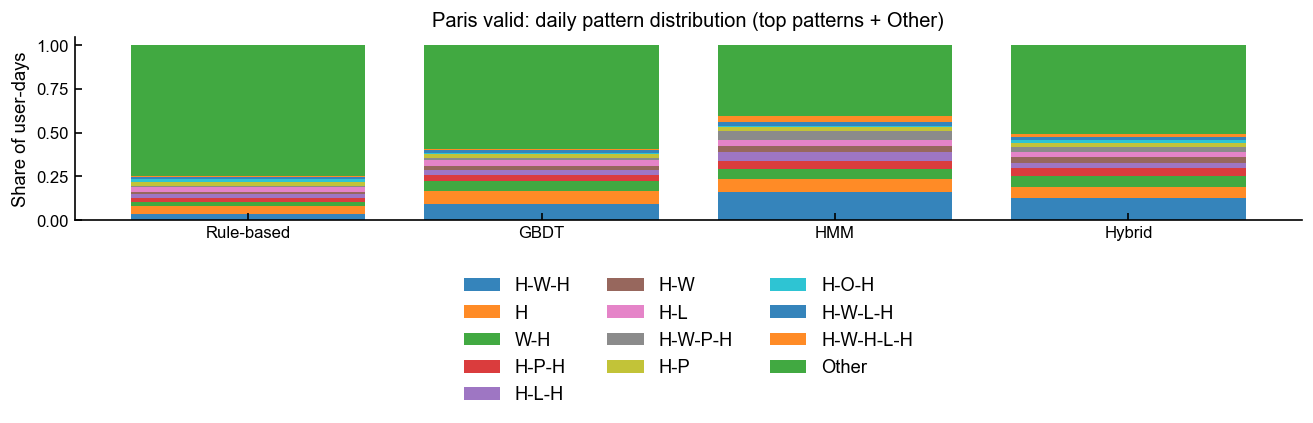

Saved: /Users/pang/Codes/GISRUK/outputs/figures/paris_pattern_share_top12_4models.png


In [21]:
apply_nature_style()
fig, ax = plt.subplots(figsize=(11, 4))
bottom = np.zeros(len(share_pat))
x = np.arange(len(share_pat))

cols = top_patterns + ["Other"]
for ptn in cols:
    ax.bar(x, share_pat[ptn].values, bottom=bottom, label=ptn, alpha=0.9)
    bottom += share_pat[ptn].values

ax.set_xticks(x)
ax.set_xticklabels(share_pat.index.tolist())
ax.set_ylabel("Share of user-days")
ax.set_title("Paris valid: daily pattern distribution (top patterns + Other)")
ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, -0.22))
ax.tick_params(direction="in")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
out_png = OUT_FIG / "paris_pattern_share_top12_4models.png"
fig.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print("Saved:", out_png)

Saved: /Users/pang/Codes/GISRUK/outputs/tables/paris_motif_share_gt_vs_hybrid.csv


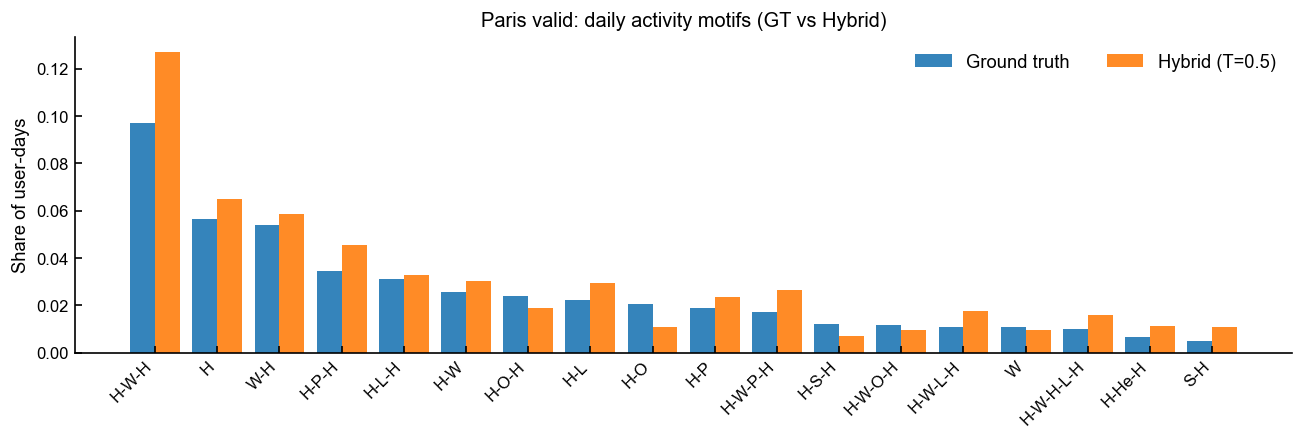

Saved: /Users/pang/Codes/GISRUK/outputs/figures/paris_motifs_gt_vs_hybrid.png


In [32]:
# Load one model's predictions on Paris valid (Hybrid); it includes y_true + y_pred
df = pd.read_parquet(OUT_DATA / "paris_valid_pred_hybrid.parquet")
df["start_time"] = pd.to_datetime(df["start_time"])
df["end_time"] = pd.to_datetime(df["end_time"])
df["duration_min"] = pd.to_numeric(df["duration_min"], errors="coerce")
df = df.dropna(subset=["user_id","start_time","end_time","duration_min","y_true","y_pred"]).copy()

def collapse_consecutive(lst):
    out=[]
    for x in lst:
        if not out or x != out[-1]:
            out.append(x)
    return out

def build_daily_motifs(df_in, label_col, min_dur_min=10, tz=TZ_PARIS, assume_utc_if_naive=False):
    d = df_in.copy()
    d["start_time"] = to_local_time_series(d["start_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
    d["end_time"]   = to_local_time_series(d["end_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
    d = split_cross_midnight(d)
    d = d[d["duration_min"] >= min_dur_min].copy()
    d["date"] = d["start_time"].dt.date

    rows=[]
    for (u, date), g in d.groupby(["user_id","date"], sort=False):
        g = g.sort_values("start_time")
        labs = [x for x in g[label_col].astype(str).tolist() if x in ABBR]
        if not labs:
            continue
        labs2 = collapse_consecutive(labs)
        motif = "-".join([ABBR[x] for x in labs2])
        rows.append(motif)
    return pd.Series(rows, name="motif")

motif_gt = build_daily_motifs(df, "y_true", min_dur_min=10)
motif_pr = build_daily_motifs(df, "y_pred", min_dur_min=10)

# Compare top motifs (union of top-K)
K = 15
top_gt = motif_gt.value_counts().head(K)
top_pr = motif_pr.value_counts().head(K)
motifs = sorted(set(top_gt.index).union(set(top_pr.index)))

cmp = pd.DataFrame({
    "GT": (motif_gt.value_counts(normalize=True).reindex(motifs, fill_value=0)),
    "Pred": (motif_pr.value_counts(normalize=True).reindex(motifs, fill_value=0)),
}).sort_values("GT", ascending=False)

cmp.to_csv(OUT_TAB / "paris_motif_share_gt_vs_hybrid.csv")
print("Saved:", OUT_TAB / "paris_motif_share_gt_vs_hybrid.csv")

apply_nature_style()
fig, ax = plt.subplots(figsize=(11, 3.8))
x = np.arange(len(cmp))
ax.bar(x-0.2, cmp["GT"].values, width=0.4, label="Ground truth", alpha=0.9)
ax.bar(x+0.2, cmp["Pred"].values, width=0.4, label="Hybrid (T=0.5)", alpha=0.9)
ax.set_xticks(x)
ax.set_xticklabels(cmp.index.tolist(), rotation=45, ha="right")
ax.set_ylabel("Share of user-days")
ax.set_title("Paris valid: daily activity motifs (GT vs Hybrid)")
ax.legend(ncol=2, loc="upper right")
ax.tick_params(direction="in")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
outpng = OUT_FIG / "paris_motifs_gt_vs_hybrid.png"
fig.savefig(outpng, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print("Saved:", outpng)

Saved: /Users/pang/Codes/GISRUK/outputs/tables/paris_motif_share_gt_rule_gbdt_hybrid.csv


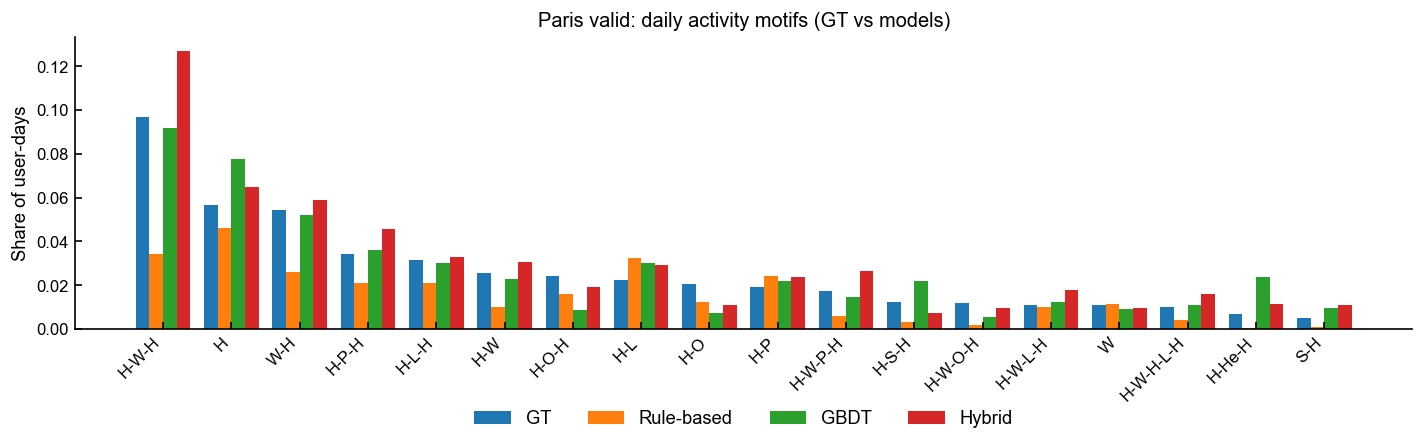

Saved: /Users/pang/Codes/GISRUK/outputs/figures/paris_motifs_gt_vs_models.png


In [37]:
def collapse_consecutive(lst):
    out=[]
    for x in lst:
        if not out or x!=out[-1]:
            out.append(x)
    return out

def build_daily_motifs(df_in, label_col, min_dur_min=10, tz=TZ_PARIS):
    d = df_in.copy()
    d["start_time"] = to_local_time_series(d["start_time"], tz=tz, assume_utc_if_naive=False)
    d["end_time"]   = to_local_time_series(d["end_time"], tz=tz, assume_utc_if_naive=False)
    d["duration_min"] = pd.to_numeric(d["duration_min"], errors="coerce")
    d = split_cross_midnight(d)
    d = d[d["duration_min"] >= min_dur_min].copy()
    d["date"] = d["start_time"].dt.date

    rows=[]
    for (u, date), g in d.groupby(["user_id","date"], sort=False):
        g = g.sort_values("start_time")
        labs = [x for x in g[label_col].astype(str).tolist() if x in ABBR]
        if not labs:
            continue
        labs2 = collapse_consecutive(labs)
        rows.append("-".join([ABBR[x] for x in labs2]))
    return pd.Series(rows, name="motif")

# Load parquets (ensure they exist)
df_rule = pd.read_parquet(OUT_DATA / "paris_valid_pred_rulebased.parquet")
df_gbdt = pd.read_parquet(OUT_DATA / "paris_valid_pred_gbdt.parquet")
df_hybr = pd.read_parquet(OUT_DATA / "paris_valid_pred_hybrid.parquet")

for d in [df_rule, df_gbdt, df_hybr]:
    d["start_time"] = pd.to_datetime(d["start_time"])
    d["end_time"] = pd.to_datetime(d["end_time"])
    d["duration_min"] = pd.to_numeric(d["duration_min"], errors="coerce")

mot_gt   = build_daily_motifs(df_hybr, "y_true")
mot_rule = build_daily_motifs(df_rule.rename(columns={"y_pred":"pred"}), "pred")
mot_gbdt = build_daily_motifs(df_gbdt.rename(columns={"y_pred":"pred"}), "pred")
mot_hybr = build_daily_motifs(df_hybr, "y_pred")

K = 15
motifs = sorted(set(mot_gt.value_counts().head(K).index)
                | set(mot_hybr.value_counts().head(K).index))

cmp = pd.DataFrame({
    "GT":    mot_gt.value_counts(normalize=True).reindex(motifs, fill_value=0),
    "Rule":  mot_rule.value_counts(normalize=True).reindex(motifs, fill_value=0),
    "GBDT":  mot_gbdt.value_counts(normalize=True).reindex(motifs, fill_value=0),
    "Hybrid":mot_hybr.value_counts(normalize=True).reindex(motifs, fill_value=0),
}).sort_values("GT", ascending=False)

cmp.to_csv(OUT_TAB / "paris_motif_share_gt_rule_gbdt_hybrid.csv")
print("Saved:", OUT_TAB / "paris_motif_share_gt_rule_gbdt_hybrid.csv")

apply_nature_style()
fig, ax = plt.subplots(figsize=(12, 4))
x = np.arange(len(cmp))
w = 0.2
ax.bar(x-1.5*w, cmp["GT"].values, width=w, label="GT")
ax.bar(x-0.5*w, cmp["Rule"].values, width=w, label="Rule-based")
ax.bar(x+0.5*w, cmp["GBDT"].values, width=w, label="GBDT")
ax.bar(x+1.5*w, cmp["Hybrid"].values, width=w, label="Hybrid")
ax.set_xticks(x)
ax.set_xticklabels(cmp.index.tolist(), rotation=45, ha="right")
ax.set_ylabel("Share of user-days")
ax.set_title("Paris valid: daily activity motifs (GT vs models)")
ax.legend(ncol=4, loc="upper center", bbox_to_anchor=(0.5, -0.22))
ax.tick_params(direction="in")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
outpng = OUT_FIG / "paris_motifs_gt_vs_models.png"
fig.savefig(outpng, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print("Saved:", outpng)

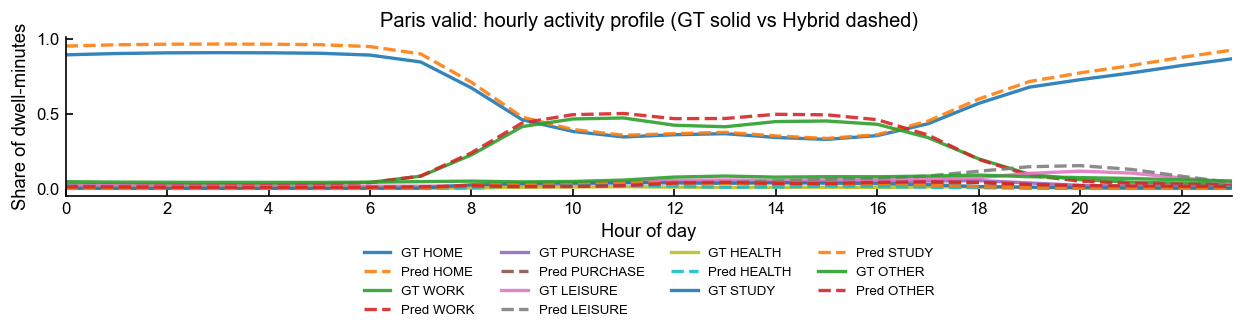

Saved: /Users/pang/Codes/GISRUK/outputs/figures/paris_hourly_profile_gt_vs_hybrid.png
Saved hourly tables.


In [23]:
def hourly_profile_by_dwell(df_in, label_col, tz=TZ_PARIS, assume_utc_if_naive=False):
    d = df_in.copy()
    d["start_time"] = to_local_time_series(d["start_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
    d["end_time"]   = to_local_time_series(d["end_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
    d = split_cross_midnight(d)

    # expand into hourly bins by allocating minutes to each hour block
    rows=[]
    for r in d.itertuples(index=False):
        st, en = r.start_time, r.end_time
        lab = getattr(r, label_col)
        cur = st
        while cur < en:
            nxt = min(en, (cur.floor("H") + pd.Timedelta(hours=1)))
            mins = (nxt - cur).total_seconds()/60.0
            rows.append((cur.hour, str(lab), mins))
            cur = nxt

    tmp = pd.DataFrame(rows, columns=["hour","label","mins"])
    tab = tmp.pivot_table(index="hour", columns="label", values="mins", aggfunc="sum", fill_value=0)
    # ensure 0..23
    tab = tab.reindex(range(24), fill_value=0)
    share = tab.div(tab.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
    return share

share_gt = hourly_profile_by_dwell(df, "y_true")
share_pr = hourly_profile_by_dwell(df, "y_pred")

apply_nature_style()
fig, ax = plt.subplots(figsize=(10.5, 3.2))
x = np.arange(24)

# Plot HOME/WORK/PURCHASE/LEISURE/OTHER as example lines (you can add more)
for lab in ["HOME","WORK","PURCHASE","LEISURE","HEALTH","STUDY","OTHER"]:
    ax.plot(x, share_gt.get(lab, pd.Series(0,index=range(24))).values, label=f"GT {lab}", alpha=0.9)
    ax.plot(x, share_pr.get(lab, pd.Series(0,index=range(24))).values, linestyle="--", label=f"Pred {lab}", alpha=0.9)

ax.set_xlim(0,23)
ax.set_xticks(np.arange(0,24,2))
ax.set_xlabel("Hour of day")
ax.set_ylabel("Share of dwell-minutes")
ax.set_title("Paris valid: hourly activity profile (GT solid vs Hybrid dashed)")
ax.legend(ncol=4, fontsize=8, loc="upper center", bbox_to_anchor=(0.5, -0.25))
ax.tick_params(direction="in")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
outpng = OUT_FIG / "paris_hourly_profile_gt_vs_hybrid.png"
fig.savefig(outpng, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print("Saved:", outpng)

# Save tables
share_gt.to_csv(OUT_TAB / "paris_hourly_profile_gt.csv")
share_pr.to_csv(OUT_TAB / "paris_hourly_profile_hybrid.csv")
print("Saved hourly tables.")

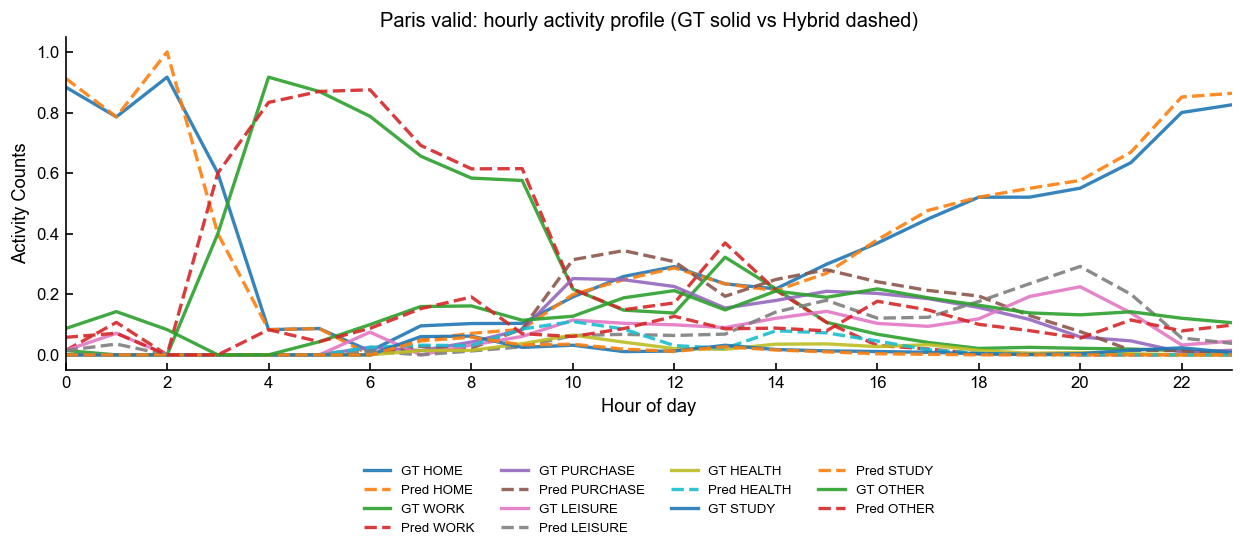

Saved: /Users/pang/Codes/GISRUK/outputs/figures/paris_hourly_profile_counts_gt_vs_hybrid.png
Saved hourly tables.


In [29]:
def hourly_profile_by_count(df_in, label_col, tz=TZ_PARIS, assume_utc_if_naive=False):
    d = df_in.copy()
    d["start_time"] = to_local_time_series(d["start_time"], tz=tz, assume_utc_if_naive=assume_utc_if_naive)
    d["hour"] = d["start_time"].dt.hour
    tmp = d.groupby(["hour", d[label_col].astype(str)]).size().reset_index(name="n")
    tab = tmp.pivot_table(index="hour", columns=label_col, values="n", aggfunc="sum", fill_value=0)
    tab = tab.reindex(range(24), fill_value=0)
    share = tab.div(tab.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
    return share

share_gt = hourly_profile_by_count(df, "y_true")
share_pr = hourly_profile_by_count(df, "y_pred")

apply_nature_style()
fig, ax = plt.subplots(figsize=(10.5, 5))
x = np.arange(24)

# Plot HOME/WORK/PURCHASE/LEISURE/OTHER as example lines (you can add more)
for lab in ["HOME","WORK","PURCHASE","LEISURE","HEALTH","STUDY","OTHER"]:
    ax.plot(x, share_gt.get(lab, pd.Series(0,index=range(24))).values, label=f"GT {lab}", alpha=0.9)
    ax.plot(x, share_pr.get(lab, pd.Series(0,index=range(24))).values, linestyle="--", label=f"Pred {lab}", alpha=0.9)

ax.set_xlim(0,23)
ax.set_xticks(np.arange(0,24,2))
ax.set_xlabel("Hour of day")
ax.set_ylabel("Activity Counts")
ax.set_title("Paris valid: hourly activity profile (GT solid vs Hybrid dashed)")
ax.legend(ncol=4, fontsize=8, loc="upper center", bbox_to_anchor=(0.5, -0.25))
ax.tick_params(direction="in")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
outpng = OUT_FIG / "paris_hourly_profile_counts_gt_vs_hybrid.png"
fig.savefig(outpng, dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
print("Saved:", outpng)

# Save tables
share_gt.to_csv(OUT_TAB / "paris_hourly_profile_gt.csv")
share_pr.to_csv(OUT_TAB / "paris_hourly_profile_hybrid.csv")
print("Saved hourly tables.")

Coverage rule/hmm/hybrid: 1.0 1.0 1.0
Saved: /Users/pang/Codes/GISRUK/outputs/tables/paris_motif_share_gt_rule_hmm_hybrid_min10.csv


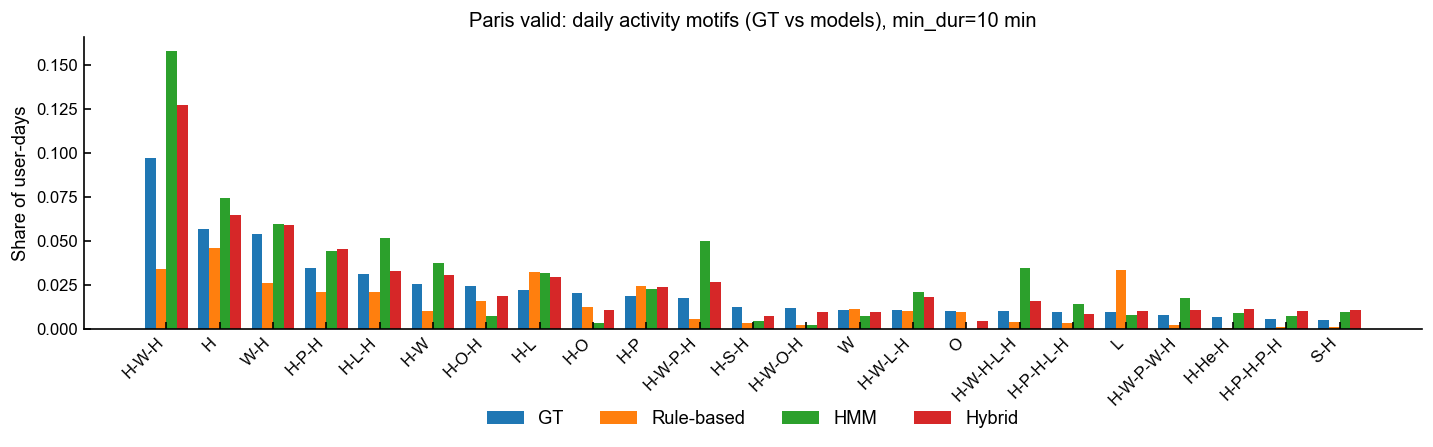

Saved: /Users/pang/Codes/GISRUK/outputs/figures/paris_motifs_gt_rule_hmm_hybrid_min10.png


In [42]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.utils_time import to_local_time_series, split_cross_midnight
from src.viz_style import apply_nature_style
from src.config import TZ_PARIS, ABBR

ROOT = Path("/Users/pang/Codes/GISRUK")
OUT_DATA = ROOT / "outputs" / "data"
OUT_TAB  = ROOT / "outputs" / "tables"
OUT_FIG  = ROOT / "outputs" / "figures"
OUT_TAB.mkdir(parents=True, exist_ok=True)
OUT_FIG.mkdir(parents=True, exist_ok=True)

# ---- base stays (single source of truth) ----
base = pd.read_parquet(OUT_DATA / "paris_stays_valid.parquet")
base["user_id"] = base["user_id"].astype(str)
base["start_time"] = pd.to_datetime(base["start_time"])
base["end_time"] = pd.to_datetime(base["end_time"])
base["duration_min"] = pd.to_numeric(base["duration_min"], errors="coerce")
base["hex_id"] = base["hex_id"].astype(str)
base["y_true"] = base["y_true"].astype(str)

KEYS = ["user_id","start_time","end_time","hex_id"]

def load_pred(path, out_col):
    d = pd.read_parquet(path)
    d["user_id"] = d["user_id"].astype(str)
    d["start_time"] = pd.to_datetime(d["start_time"])
    d["end_time"] = pd.to_datetime(d["end_time"])
    d["hex_id"] = d["hex_id"].astype(str)
    d["y_pred"] = d["y_pred"].astype(str)
    return d[KEYS + ["y_pred"]].rename(columns={"y_pred": out_col})

pred_rule = load_pred(OUT_DATA / "paris_valid_pred_rulebased.parquet", "pred_rule")
pred_hmm  = load_pred(OUT_DATA / "paris_valid_pred_hmm.parquet", "pred_hmm")
pred_hybr = load_pred(OUT_DATA / "paris_valid_pred_hybrid.parquet", "pred_hybrid")

df = base.merge(pred_rule, on=KEYS, how="left") \
         .merge(pred_hmm,  on=KEYS, how="left") \
         .merge(pred_hybr, on=KEYS, how="left")

print("Coverage rule/hmm/hybrid:",
      df["pred_rule"].notna().mean(),
      df["pred_hmm"].notna().mean(),
      df["pred_hybrid"].notna().mean())

def collapse_consecutive(lst):
    out=[]
    for x in lst:
        if not out or x!=out[-1]:
            out.append(x)
    return out

def build_daily_motifs(df_in, label_col, min_dur_min=10, tz=TZ_PARIS):
    d = df_in.copy()
    d["start_time"] = to_local_time_series(d["start_time"], tz=tz, assume_utc_if_naive=False)
    d["end_time"]   = to_local_time_series(d["end_time"], tz=tz, assume_utc_if_naive=False)
    d = split_cross_midnight(d)
    d = d[d["duration_min"] >= float(min_dur_min)].copy()
    d["date"] = d["start_time"].dt.date

    motifs=[]
    for (u, date), g in d.groupby(["user_id","date"], sort=False):
        g = g.sort_values("start_time")
        labs = [x for x in g[label_col].astype(str).tolist() if x in ABBR]
        if not labs:
            continue
        labs2 = collapse_consecutive(labs)
        motifs.append("-".join([ABBR[x] for x in labs2]))
    return pd.Series(motifs, name="motif")

def plot_motif_compare(min_dur_min=5, K=18):
    series = {
        "GT": build_daily_motifs(df, "y_true", min_dur_min=min_dur_min),
        "Rule-based": build_daily_motifs(df.dropna(subset=["pred_rule"]), "pred_rule", min_dur_min=min_dur_min),
        "HMM": build_daily_motifs(df.dropna(subset=["pred_hmm"]), "pred_hmm", min_dur_min=min_dur_min),
        "Hybrid": build_daily_motifs(df.dropna(subset=["pred_hybrid"]), "pred_hybrid", min_dur_min=min_dur_min),
    }

    # motif set = union of top-K from GT and Hybrid (stable & interpretable)
    top = set(series["GT"].value_counts().head(K).index) | set(series["Hybrid"].value_counts().head(K).index)
    motifs = list(top)

    cmp = pd.DataFrame({k: v.value_counts(normalize=True).reindex(motifs, fill_value=0) for k,v in series.items()})
    cmp = cmp.sort_values("GT", ascending=False)

    out_csv = OUT_TAB / f"paris_motif_share_gt_rule_hmm_hybrid_min{min_dur_min}.csv"
    cmp.to_csv(out_csv)
    print("Saved:", out_csv)

    apply_nature_style()
    fig, ax = plt.subplots(figsize=(12,4))
    x = np.arange(len(cmp))
    w = 0.2
    ax.bar(x-1.5*w, cmp["GT"].values, width=w, label="GT")
    ax.bar(x-0.5*w, cmp["Rule-based"].values, width=w, label="Rule-based")
    ax.bar(x+0.5*w, cmp["HMM"].values, width=w, label="HMM")
    ax.bar(x+1.5*w, cmp["Hybrid"].values, width=w, label="Hybrid")
    ax.set_xticks(x)
    ax.set_xticklabels(cmp.index.tolist(), rotation=45, ha="right")
    ax.set_ylabel("Share of user-days")
    ax.set_title(f"Paris valid: daily activity motifs (GT vs models), min_dur={min_dur_min} min")
    ax.legend(ncol=4, loc="upper center", bbox_to_anchor=(0.5, -0.22))
    ax.tick_params(direction="in")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    out_png = OUT_FIG / f"paris_motifs_gt_rule_hmm_hybrid_min{min_dur_min}.png"
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print("Saved:", out_png)

# run once (recommend 10; keep it consistent in the paper)
plot_motif_compare(min_dur_min=10, K=18)

In [43]:
uk_files = {
    "Rule-based": OUT_DATA / "uk_1w_pred_rulebased.parquet",
    "GBDT":       OUT_DATA / "uk_1w_pred_gbdt.parquet",
    "HMM":        OUT_DATA / "uk_1w_pred_hmm.parquet",
    "Hybrid":     OUT_DATA / "uk_1w_pred_hybrid.parquet",
    "Hybrid(OD-normalized)": OUT_DATA / "uk_1w_pred_hybrid_od.parquet",
}

uk = {}
for name, p in uk_files.items():
    if not p.exists():
        continue
    d = pd.read_parquet(p)
    if "user_id" not in d.columns and "userid" in d.columns:
        d = d.rename(columns={"userid":"user_id"})
    d["user_id"] = d["user_id"].astype(str)
    d["start_time"] = pd.to_datetime(d["start_time"], errors="coerce")
    d["end_time"] = pd.to_datetime(d["end_time"], errors="coerce")
    if "duration_min" not in d.columns:
        d["duration_min"] = (d["end_time"] - d["start_time"]).dt.total_seconds()/60.0
    d["duration_min"] = pd.to_numeric(d["duration_min"], errors="coerce")
    # unify prediction column to y_pred
    if "label_od" in d.columns:
        d["y_pred"] = d["label_od"].astype(str)
    elif "y_pred" in d.columns:
        d["y_pred"] = d["y_pred"].astype(str)
    elif "label" in d.columns:
        d["y_pred"] = d["label"].astype(str)
    else:
        raise ValueError(f"No prediction column found in {p.name}")
    uk[name] = d.dropna(subset=["user_id","start_time","end_time","duration_min","y_pred"]).copy()

print("Loaded models:", list(uk.keys()))

Loaded models: ['Rule-based', 'GBDT', 'HMM', 'Hybrid', 'Hybrid(OD-normalized)']


In [44]:
for name, dfm in uk.items():
    print("\n", name)
    print(dfm["y_pred"].value_counts(normalize=True).head(7))


 Rule-based
HOME        0.437605
WORK        0.177262
LEISURE     0.165658
PURCHASE    0.151530
STUDY       0.037504
HEALTH      0.030441
Name: y_pred, dtype: float64

 GBDT
HOME        0.423478
PURCHASE    0.149176
WORK        0.134376
HEALTH      0.131349
OTHER       0.085604
LEISURE     0.045913
STUDY       0.030104
Name: y_pred, dtype: float64

 HMM
HOME        0.422637
WORK        0.170535
PURCHASE    0.165489
HEALTH      0.136731
OTHER       0.055163
LEISURE     0.036495
STUDY       0.012950
Name: y_pred, dtype: float64

 Hybrid
HOME        0.426337
WORK        0.169021
PURCHASE    0.165489
HEALTH      0.136394
OTHER       0.052472
LEISURE     0.036495
STUDY       0.013791
Name: y_pred, dtype: float64

 Hybrid(OD-normalized)
HOME        0.416751
PURCHASE    0.165489
HEALTH      0.136394
WORK        0.136226
OTHER       0.094854
LEISURE     0.036495
STUDY       0.013791
Name: y_pred, dtype: float64


In [45]:
# quick: how many WORK stays are shorter than 10min in each model?
for name, dfm in uk.items():
    work = dfm[dfm["y_pred"]=="WORK"]
    if len(work)==0:
        print(name, "no WORK")
        continue
    print(name, "WORK <10min share:", float((work["duration_min"]<10).mean()))

Rule-based WORK <10min share: 0.03984819734345351
GBDT WORK <10min share: 0.1214017521902378
HMM WORK <10min share: 0.03353057199211045
Hybrid WORK <10min share: 0.03383084577114428
Hybrid(OD-normalized) WORK <10min share: 0.018518518518518517


In [46]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from src.viz_style import apply_nature_style
from src.utils_time import to_local_time_series, split_cross_midnight
from src.config import TZ_PARIS, ABBR

ROOT = Path("/Users/pang/Codes/GISRUK")
OUT_DATA = ROOT / "outputs" / "data"
OUT_FIG  = ROOT / "outputs" / "figures"
OUT_FIG.mkdir(parents=True, exist_ok=True)

# load base stays + merge preds (fair comparison)
base = pd.read_parquet(OUT_DATA/"paris_stays_valid.parquet")
base["user_id"]=base["user_id"].astype(str)
base["start_time"]=pd.to_datetime(base["start_time"])
base["end_time"]=pd.to_datetime(base["end_time"])
base["hex_id"]=base["hex_id"].astype(str)
base["y_true"]=base["y_true"].astype(str)
base["duration_min"]=pd.to_numeric(base["duration_min"], errors="coerce")

KEYS=["user_id","start_time","end_time","hex_id"]
def load_pred(path, out_col):
    d=pd.read_parquet(path)
    d["user_id"]=d["user_id"].astype(str)
    d["start_time"]=pd.to_datetime(d["start_time"])
    d["end_time"]=pd.to_datetime(d["end_time"])
    d["hex_id"]=d["hex_id"].astype(str)
    d["y_pred"]=d["y_pred"].astype(str)
    return d[KEYS+["y_pred"]].rename(columns={"y_pred":out_col})

df = base.merge(load_pred(OUT_DATA/"paris_valid_pred_rulebased.parquet","pred_rule"), on=KEYS, how="left") \
         .merge(load_pred(OUT_DATA/"paris_valid_pred_hmm.parquet","pred_hmm"), on=KEYS, how="left") \
         .merge(load_pred(OUT_DATA/"paris_valid_pred_hybrid.parquet","pred_hybrid"), on=KEYS, how="left")

def hourly_profile_count(df_in, label_col):
    d=df_in.copy()
    d["start_time"]=to_local_time_series(d["start_time"], tz=TZ_PARIS, assume_utc_if_naive=False)
    d["hour"]=d["start_time"].dt.hour
    tmp=d.groupby(["hour", d[label_col].astype(str)]).size().reset_index(name="n")
    tmp=tmp.rename(columns={label_col:"label"})
    tab=tmp.pivot_table(index="hour", columns="label", values="n", aggfunc="sum", fill_value=0)
    tab=tab.reindex(range(24), fill_value=0)
    return tab.div(tab.sum(axis=1).replace(0,np.nan), axis=0).fillna(0.0)

apply_nature_style()
profiles = {
    "GT": hourly_profile_count(df, "y_true"),
    "Rule-based": hourly_profile_count(df.dropna(subset=["pred_rule"]), "pred_rule"),
    "HMM": hourly_profile_count(df.dropna(subset=["pred_hmm"]), "pred_hmm"),
    "Hybrid": hourly_profile_count(df.dropna(subset=["pred_hybrid"]), "pred_hybrid"),
}

# plot selected labels
labels_plot = ["HOME","WORK","PURCHASE","LEISURE","HEALTH","OTHER"]
fig, axes = plt.subplots(len(labels_plot), 1, figsize=(10.5, 2.2*len(labels_plot)), sharex=True)
x = np.arange(24)
for ax, lab in zip(axes, labels_plot):
    for name, prof in profiles.items():
        ax.plot(x, prof.get(lab, pd.Series(0,index=range(24))).values, label=name, alpha=0.9)
    ax.set_ylabel(lab)
    ax.set_xlim(0,23)
    ax.tick_params(direction="in")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
axes[-1].set_xticks(np.arange(0,24,2))
axes[-1].set_xlabel("Hour of day")
axes[0].set_title("Paris valid: hourly activity distribution (count-based)")
axes[0].legend(ncol=4, loc="upper center", bbox_to_anchor=(0.5, 1.35), fontsize=9)
plt.tight_layout()
out = OUT_FIG/"fig_paris_hourly_count_gt_rule_hmm_hybrid.png"
fig.savefig(out, dpi=300, bbox_inches="tight")
plt.close(fig)
print("Saved:", out)

Saved: /Users/pang/Codes/GISRUK/outputs/figures/fig_paris_hourly_count_gt_rule_hmm_hybrid.png


In [47]:
import matplotlib.pyplot as plt
from src.viz_style import apply_nature_style
apply_nature_style()

models = ["Rule-based","HMM","GBDT","Hybrid"]
macro_weak = [0.2508782713, 0.3603642371, 0.4275618680, 0.4500497426]  # update if needed

fig, ax = plt.subplots(figsize=(6.5,3.2))
ax.bar(models, macro_weak, alpha=0.9)
ax.set_ylabel("Macro_weak (Macro-F1 excl HOME)")
ax.set_title("Paris valid: incremental gains across modelling components")
ax.tick_params(direction="in")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
out = Path("/Users/pang/Codes/GISRUK/outputs/figures/fig_paris_module_gain.png")
fig.savefig(out, dpi=300, bbox_inches="tight")
plt.close(fig)
print("Saved:", out)

Saved: /Users/pang/Codes/GISRUK/outputs/figures/fig_paris_module_gain.png
